# Analysis of Option Greeks: Sensitivity and Visualization

This notebook explores the behavior of **European Option Greeks**—Delta, Gamma, Theta, and Vega—under the Black-Scholes-Merton framework. The primary goal is to visualize how these risk measures react to changes in the underlying stock price, time to maturity, and volatility.

### 1. Objective
We will perform a sensitivity analysis by varying one parameter at a time while holding others constant ("Ceteris Paribus"). This allows us to observe the "shape" of risk across different market conditions (e.g., At-the-Money vs. Out-of-the-Money, or approaching expiration).

### 2. Baseline Parameters
For our analysis, we assume a standard set of initial conditions for a European Call/Put option:

- **Initial Stock Price ($S_0$):** $100$
- **Strike Price ($K$):** $105$ (The option is currently Out-of-the-Money)
- **Volatility ($\sigma$):** $25\%$ ($0.25$)
- **Risk-free Rate ($r$):** $0\%$ ($0.0$)
- **Time to Maturity ($T$):** $30$ Days (Approx. $0.0822$ years)

### 3. Mathematical Foundation: The Call Option Price
All Greeks are derived as partial derivatives of the Black-Scholes-Merton pricing formula. For a European Call option, the price ($C$) is given by:

$$
C(S, t) = S N(d_1) - K e^{-r\tau} N(d_2)
$$

Where:
- $N(\cdot)$ is the cumulative distribution function of the standard normal distribution.
- $\tau = T - t$ is the time to maturity.
- $d_1$ and $d_2$ are defined as:

$$
d_1 = \frac{\ln(S/K) + (r + \frac{\sigma^2}{2})\tau}{\sigma \sqrt{\tau}}
$$

$$
d_2 = d_1 - \sigma \sqrt{\tau}
$$

### 4. The Greeks Under Study
The Greeks represent the sensitivity of the price ($C$) to its underlying inputs:

1.  **Delta ($\Delta$):** $\frac{\partial C}{\partial S}$ — Sensitivity to the underlying price.
2.  **Gamma ($\Gamma$):** $\frac{\partial^2 C}{\partial S^2}$ — Sensitivity of Delta to the underlying price.
3.  **Theta ($\Theta$):** $\frac{\partial C}{\partial t}$ — Sensitivity to the passage of time ("time decay").
4.  **Vega ($\nu$):** $\frac{\partial C}{\partial \sigma}$ — Sensitivity to changes in implied volatility.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

class GreekStudy:
    """
    Maintains the state of our analysis parameters and provides 
    methods to calculate Greeks based on the BSM framework.
    """
    def __init__(self, S0=100.0, K=105.0, vol=0.25, r=0.0, T_days=30):
        # Baseline Parameters
        self.S0 = S0
        self.K = K
        self.vol = vol
        self.r = r
        self.T = T_days / 365.0  # Convert days to annual time
        
    def get_d1(self, S, K, T, r, sigma):
        # Avoid division by zero for expired options
        T = np.maximum(T, 1e-10)
        return (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

    def get_d2(self, d1, T, sigma):
        T = np.maximum(T, 1e-10)
        return d1 - sigma * np.sqrt(T)

    def delta(self, S=None, T=None, vol=None):
        S = S if S is not None else self.S0
        T = T if T is not None else self.T
        vol = vol if vol is not None else self.vol
        d1 = self.get_d1(S, self.K, T, self.r, vol)
        return norm.cdf(d1)

    def gamma(self, S=None, T=None, vol=None):
        S = S if S is not None else self.S0
        T = T if T is not None else self.T
        vol = vol if vol is not None else self.vol
        d1 = self.get_d1(S, self.K, T, self.r, vol)
        return norm.pdf(d1) / (S * vol * np.sqrt(T))

    def vega(self, S=None, T=None, vol=None):
        S = S if S is not None else self.S0
        T = T if T is not None else self.T
        vol = vol if vol is not None else self.vol
        d1 = self.get_d1(S, self.K, T, self.r, vol)
        # Vega is often expressed as change per 1% change in vol
        return (S * norm.pdf(d1) * np.sqrt(T)) / 100

    def theta(self, S=None, T=None, vol=None):
        S = S if S is not None else self.S0
        T = T if T is not None else self.T
        vol = vol if vol is not None else self.vol
        d1 = self.get_d1(S, self.K, T, self.r, vol)
        d2 = self.get_d2(d1, T, vol)
        
        term1 = -(S * norm.pdf(d1) * vol) / (2 * np.sqrt(T))
        term2 = self.r * self.K * np.exp(-self.r * T) * norm.cdf(d2)
        # Theta is usually expressed as decay per day
        return (term1 - term2) / 365

# Initialize the session state
study = GreekStudy()

print(f"Session state initialized with:")
print(f"S0: {study.S0}, K: {study.K}, Vol: {study.vol}, T: {study.T:.4f} yrs ({study.T*365:.0f} days)")

Session state initialized with:
S0: 100.0, K: 105.0, Vol: 0.25, T: 0.0822 yrs (30 days)


# Analysis 1: Delta ($\Delta$) Sensitivity

**Delta** measures the rate of change of the option price with respect to changes in the underlying stock price ($S$). It is often referred to as the "hedge ratio" because it represents the number of shares needed to offset the price risk of the option.

### Key Characteristics to Observe:
1. **Range:** For Call options, Delta stays between $0$ (Deep Out-of-the-Money) and $1$ (Deep In-the-Money).
2. **ATM Benchmark:** When the stock price is near the strike price ($S \approx K$), Delta is approximately $0.5$.
3. **The "Cliff" Effect:** As time to maturity ($\tau$) approaches zero, the Delta curve becomes steeper at the strike price, eventually turning into a step function at expiration.
4. **Volatility Flattening:** Higher volatility ($\sigma$) tends to "smear" the Delta curve, as it becomes less certain whether the option will finish In-the-Money.

### Scenarios for Visualization
In the following code, we will plot:
* **Delta vs. Stock Price:** To see the transition from $0$ to $1$.
* **Impact of Time:** Comparing Delta at 30 days, 10 days, and 1 day to maturity.
* **Impact of Volatility:** Comparing Delta at $10\%$, $25\%$, and $50\%$ volatility.

$$ \Delta = \frac{\partial C}{\partial S} = N(d_1) $$

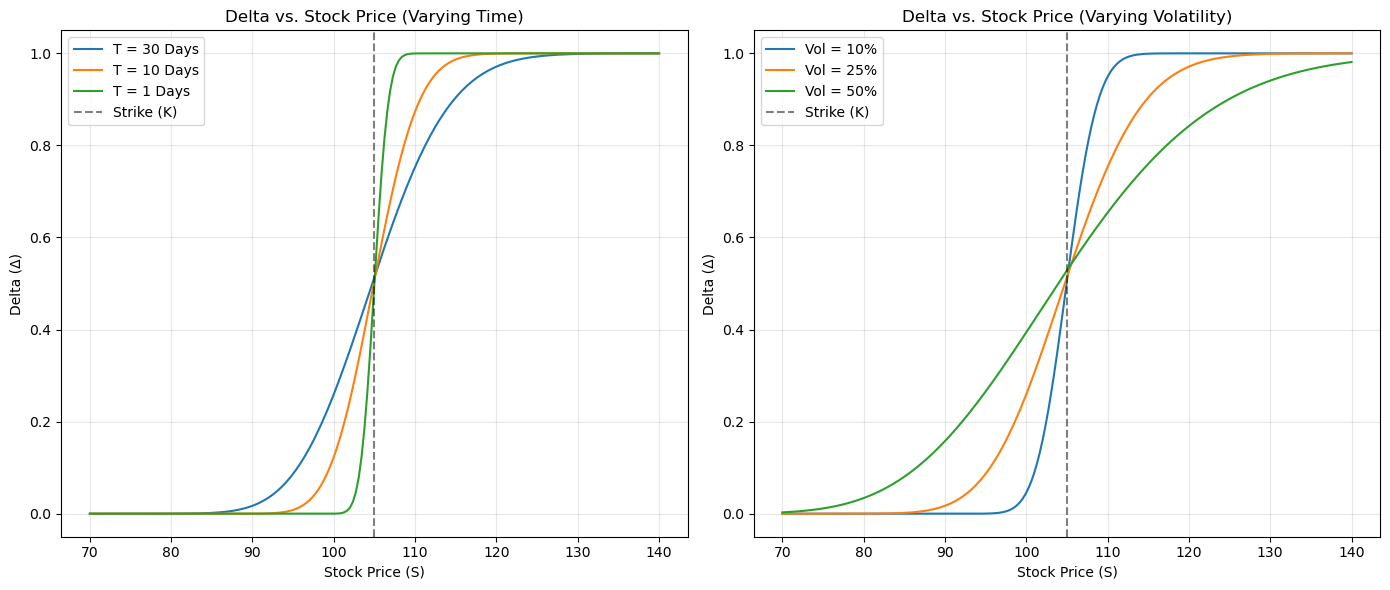

In [4]:
# Create a range of stock prices around the strike price (K=105)
S_range = np.linspace(70, 140, 200)

plt.figure(figsize=(14, 6))

# --- Plot 1: Impact of Time to Maturity ---
plt.subplot(1, 2, 1)
for days in [30, 10, 1]:
    T_years = days / 365
    plt.plot(S_range, study.delta(S=S_range, T=T_years), label=f'T = {days} Days')

plt.axvline(study.K, color='black', linestyle='--', alpha=0.5, label='Strike (K)')
plt.title('Delta vs. Stock Price (Varying Time)')
plt.xlabel('Stock Price (S)')
plt.ylabel('Delta (Δ)')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot 2: Impact of Volatility ---
plt.subplot(1, 2, 2)
for v in [0.10, 0.25, 0.50]:
    plt.plot(S_range, study.delta(S=S_range, vol=v), label=f'Vol = {v*100:.0f}%')

plt.axvline(study.K, color='black', linestyle='--', alpha=0.5, label='Strike (K)')
plt.title('Delta vs. Stock Price (Varying Volatility)')
plt.xlabel('Stock Price (S)')
plt.ylabel('Delta (Δ)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis 2: Gamma ($\Gamma$) Sensitivity

**Gamma** measures the rate of change of Delta with respect to changes in the underlying stock price ($S$). It represents the **convexity** (curvature) of the option's value. If Delta is the "velocity" of the option price, Gamma is the "acceleration."

### Key Characteristics to Observe:
1. **Always Positive:** For long Call and Put options, Gamma is always positive, meaning the option's price increases at an increasing rate as it moves In-the-Money.
2. **The ATM Peak:** Gamma is highest when the stock price is near the strike price ($S \approx K$). This is where Delta is most sensitive to price changes.
3. **The "Explosion" at Expiration:** For At-the-Money options, Gamma increases dramatically as time to maturity approaches zero. This represents the extreme uncertainty of whether the option will expire worthless or as a full share.
4. **Volatility Dampening:** Higher volatility spreads the Gamma over a wider range of stock prices, lowering the peak value.

### Scenarios for Visualization
In the following code, we will plot:
* **Gamma vs. Stock Price:** To see the bell-shaped curve centered at the strike.
* **Impact of Time:** Observing the "Gamma spike" as we move from 30 days to 1 day.
* **Impact of Volatility:** Comparing the "sharpness" of Gamma at low vs. high volatility.

$$ \Gamma = \frac{\partial^2 C}{\partial S^2} = \frac{n(d_1)}{S \sigma \sqrt{\tau}} $$

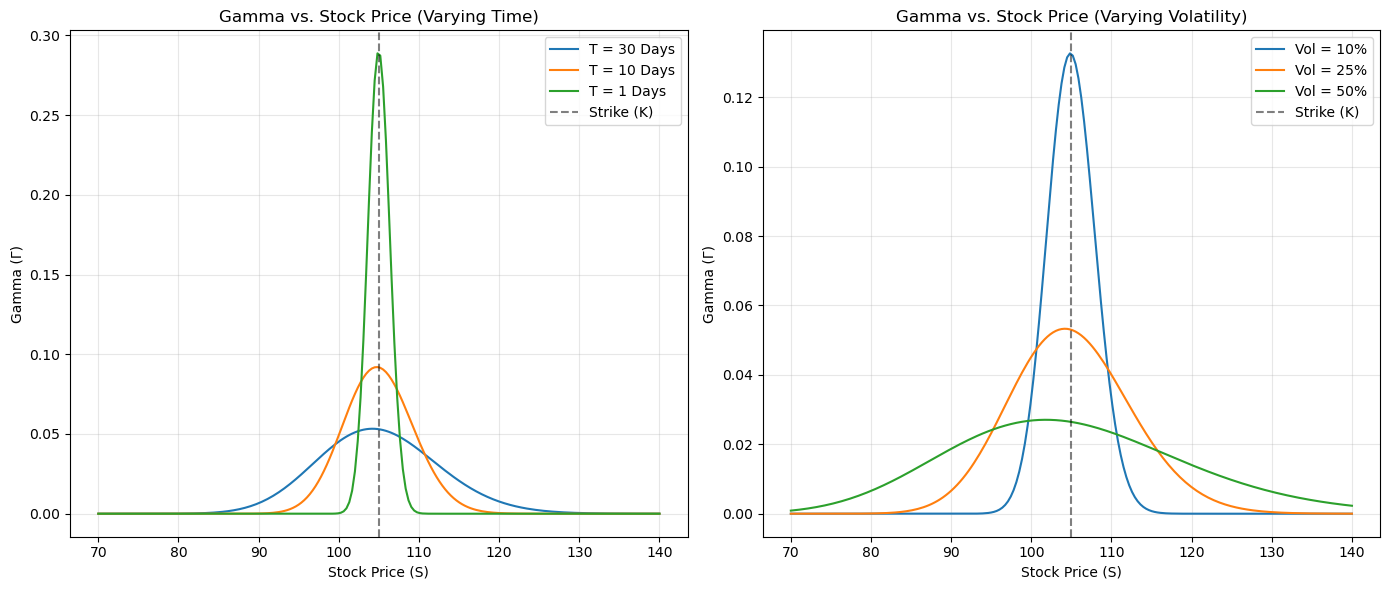

In [5]:
# Create a range of stock prices around the strike price (K=105)
S_range = np.linspace(70, 140, 200)

plt.figure(figsize=(14, 6))

# --- Plot 1: Impact of Time to Maturity ---
plt.subplot(1, 2, 1)
for days in [30, 10, 1]:
    T_years = days / 365
    plt.plot(S_range, study.gamma(S=S_range, T=T_years), label=f'T = {days} Days')

plt.axvline(study.K, color='black', linestyle='--', alpha=0.5, label='Strike (K)')
plt.title('Gamma vs. Stock Price (Varying Time)')
plt.xlabel('Stock Price (S)')
plt.ylabel('Gamma (Γ)')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot 2: Impact of Volatility ---
plt.subplot(1, 2, 2)
for v in [0.10, 0.25, 0.50]:
    plt.plot(S_range, study.gamma(S=S_range, vol=v), label=f'Vol = {v*100:.0f}%')

plt.axvline(study.K, color='black', linestyle='--', alpha=0.5, label='Strike (K)')
plt.title('Gamma vs. Stock Price (Varying Volatility)')
plt.xlabel('Stock Price (S)')
plt.ylabel('Gamma (Γ)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis 3: Theta ($\Theta$) Sensitivity

**Theta** measures the sensitivity of the option price to the passage of time, commonly known as **time decay**. For long option positions, Theta is almost always negative, representing the daily loss in value as the option approaches expiration.

### Key Characteristics to Observe:
1. **Negative Value:** Time is the "enemy" of the option buyer. Every day that passes with no movement in the stock price results in a loss of extrinsic (time) value.
2. **ATM Decay Acceleration:** Theta is typically most negative for **At-the-Money (ATM)** options. As expiration approaches, the decay for ATM options accelerates rapidly.
3. **OTM/ITM Decay Deceleration:** For options that are deep Out-of-the-Money (OTM) or deep In-the-Money (ITM), Theta actually approaches zero near expiration because there is very little time value left to lose.
4. **Volatility Impact:** Higher volatility increases the time value of an option, which consequently leads to a higher (more negative) Theta.

### Scenarios for Visualization
In the following code, we will plot:
* **Theta vs. Stock Price:** To see the "decay valley" centered at the strike.
* **Impact of Time:** Observing how the ATM decay deepens as we move from 30 days to 1 day.
* **Impact of Volatility:** Comparing how volatility scales the rate of time decay.

$$ \Theta = \frac{\partial C}{\partial t} \approx -\frac{S n(d_1) \sigma}{2 \sqrt{\tau}} - r K e^{-r\tau} N(d_2) $$


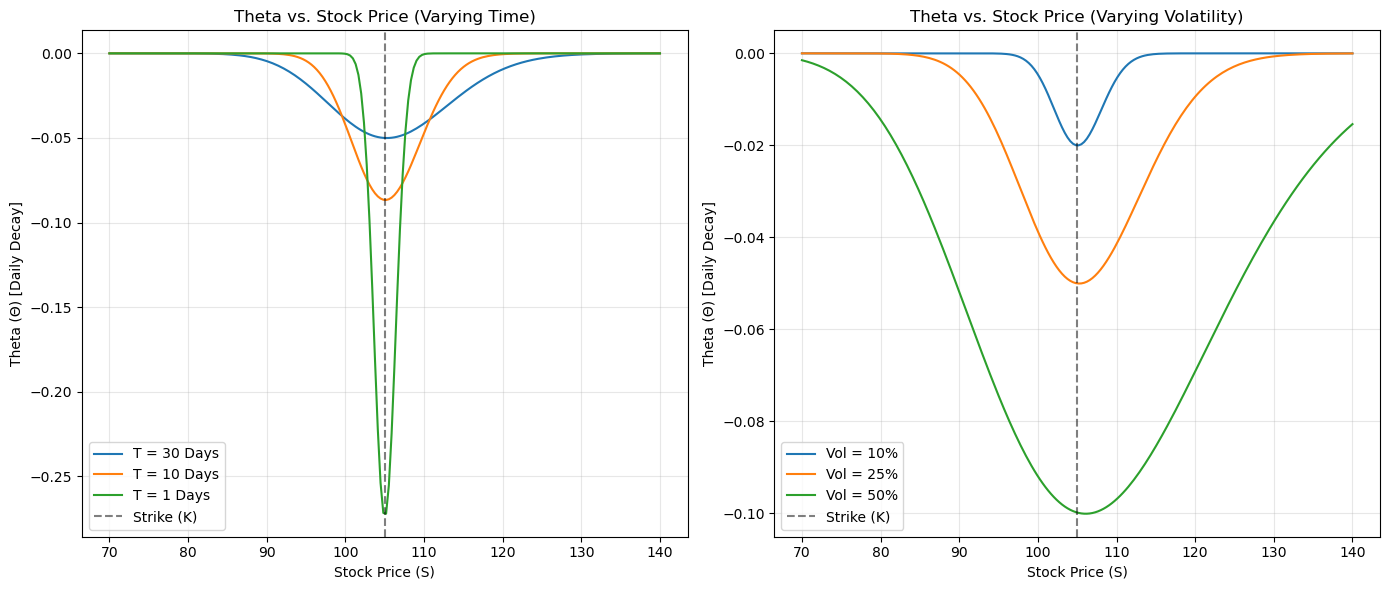

In [6]:
# Create a range of stock prices around the strike price (K=105)
S_range = np.linspace(70, 140, 200)

plt.figure(figsize=(14, 6))

# --- Plot 1: Impact of Time to Maturity ---
plt.subplot(1, 2, 1)
for days in [30, 10, 1]:
    T_years = days / 365
    plt.plot(S_range, study.theta(S=S_range, T=T_years), label=f'T = {days} Days')

plt.axvline(study.K, color='black', linestyle='--', alpha=0.5, label='Strike (K)')
plt.title('Theta vs. Stock Price (Varying Time)')
plt.xlabel('Stock Price (S)')
plt.ylabel('Theta (Θ) [Daily Decay]')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot 2: Impact of Volatility ---
plt.subplot(1, 2, 2)
for v in [0.10, 0.25, 0.50]:
    plt.plot(S_range, study.theta(S=S_range, vol=v), label=f'Vol = {v*100:.0f}%')

plt.axvline(study.K, color='black', linestyle='--', alpha=0.5, label='Strike (K)')
plt.title('Theta vs. Stock Price (Varying Volatility)')
plt.xlabel('Stock Price (S)')
plt.ylabel('Theta (Θ) [Daily Decay]')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analysis 4: Vega ($\nu$) Sensitivity

**Vega** measures the sensitivity of the option price to changes in **implied volatility** ($\sigma$). It represents the change in the option's price for every $1\%$ change in the volatility of the underlying asset.

### Key Characteristics to Observe:
1. **Always Positive:** For long Call and Put options, Vega is always positive. An increase in volatility increases the probability of the option finishing deep In-the-Money, thus increasing its price.
2. **The ATM Peak:** Like Gamma and Theta, Vega is highest for **At-the-Money (ATM)** options. These options are the most sensitive to whether the market becomes more or less volatile.
3. **Time Sensitivity:** Vega decreases as the option approaches expiration. With less time remaining, a change in volatility has less "time" to impact the eventual outcome of the option.
4. **Symmetry:** Vega is identical for both Call and Put options.

### Scenarios for Visualization
In the following code, we will plot:
* **Vega vs. Stock Price:** To see the bell-shaped sensitivity curve.
* **Impact of Time:** Comparing how Vega diminishes as we move from 30 days to 1 day to maturity.

$$ \nu = \frac{\partial C}{\partial \sigma} = S n(d_1) \sqrt{\tau} $$

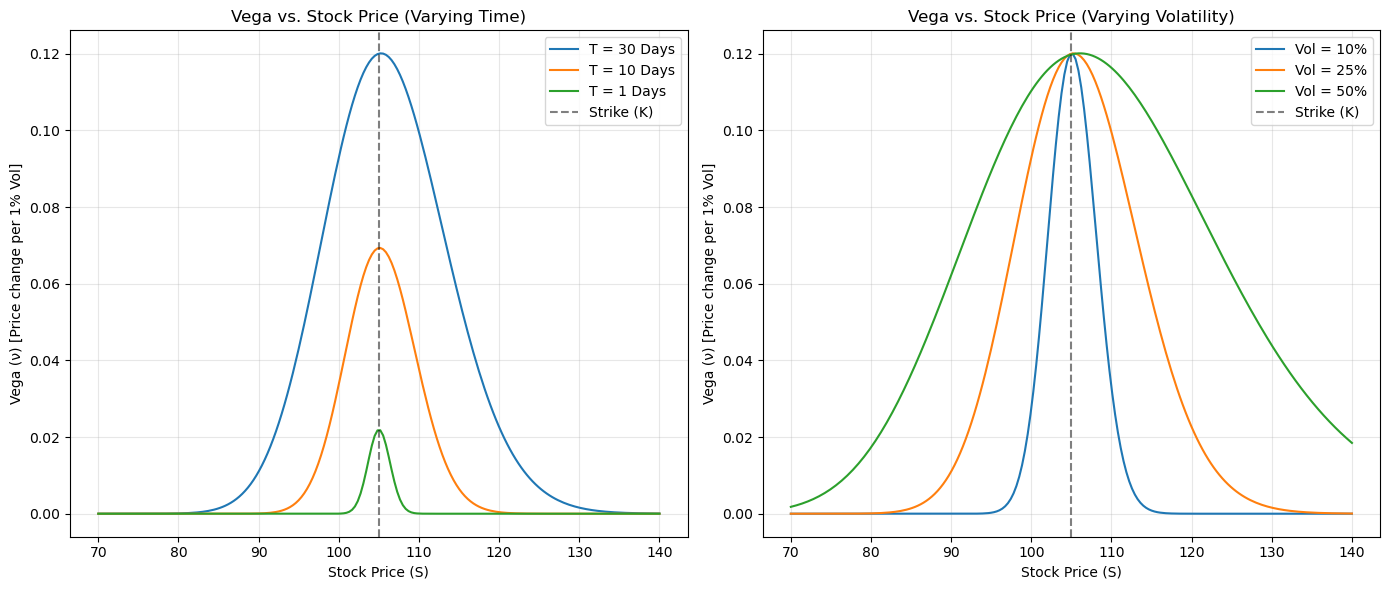

In [7]:
# Create a range of stock prices around the strike price (K=105)
S_range = np.linspace(70, 140, 200)

plt.figure(figsize=(14, 6))

# --- Plot 1: Impact of Time to Maturity ---
plt.subplot(1, 2, 1)
for days in [30, 10, 1]:
    T_years = days / 365
    plt.plot(S_range, study.vega(S=S_range, T=T_years), label=f'T = {days} Days')

plt.axvline(study.K, color='black', linestyle='--', alpha=0.5, label='Strike (K)')
plt.title('Vega vs. Stock Price (Varying Time)')
plt.xlabel('Stock Price (S)')
plt.ylabel('Vega (ν) [Price change per 1% Vol]')
plt.legend()
plt.grid(True, alpha=0.3)

# --- Plot 2: Impact of Volatility Level ---
# Vega itself is a measure of sensitivity to vol, but its magnitude 
# depends on the starting volatility level.
plt.subplot(1, 2, 2)
for v in [0.10, 0.25, 0.50]:
    plt.plot(S_range, study.vega(S=S_range, vol=v), label=f'Vol = {v*100:.0f}%')

plt.axvline(study.K, color='black', linestyle='--', alpha=0.5, label='Strike (K)')
plt.title('Vega vs. Stock Price (Varying Volatility)')
plt.xlabel('Stock Price (S)')
plt.ylabel('Vega (ν) [Price change per 1% Vol]')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary of Findings: The "Risk Landscape"

Through this sensitivity analysis, we have observed how the "Greeks" create a dynamic map of risk for a European Call option.

### 1. The At-the-Money (ATM) Focal Point
The strike price ($K=105$) acts as a focal point for nearly all risk measures:
* **Gamma, Theta, and Vega** all reach their maximum (or most negative) magnitudes when the stock is **At-the-Money**. [[2-9]][[2-12]][[2-15]]
* **Delta** is at its most "undecided" state $(\approx 0.5)$ at this point, representing the highest uncertainty regarding the option's final payoff. [[2-6]]

### 2. The Impact of Time (Passage toward Expiration)
As time to maturity approaches zero ($\tau \to 0$):
* **Delta** sharpens into a step-function, creating a "cliff" at the strike price. [[2-6]]
* **Gamma** and **Theta** explode in magnitude for ATM options, representing extreme "Pin Risk" and rapid value erosion. [[2-9]][[2-12]]
* **Vega** collapses, as there is no time left for volatility to impact the outcome. [[2-15]]

### 3. The Impact of Volatility
Higher volatility ($\sigma$) serves to "smear" or "flatten" the risk curves:
* **Delta** becomes a smoother, flatter line, as high volatility makes it less certain whether an option will finish ITM or OTM. [[2-6]]
* **Gamma** peaks are lowered and spread over a wider price range. [[2-9]]
* **Theta** becomes more negative across the board, as volatile options carry higher time-value premiums that must eventually decay. [[2-12]]

### Conclusion for Risk Management
Understanding these sensitivities is crucial for **Delta-Neutral Hedging**. A trader must not only manage the directional risk (Delta) but also be aware of how their exposure will "accelerate" (Gamma), "bleed" (Theta), or "expand" (Vega) as market conditions and time evolve.